In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Normalize, Resize
import pandas as pd
from tqdm.notebook import tqdm
import os
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
args = {}
# path declaration
args['DATA_DIR'] = 'data/DaanForestPark'
args['LABEL_DIR'] = 'label2.csv'
args['IMAGE_DIR'] = args['DATA_DIR']
# model configurations
args['VALID_RATIO'] = .2
args['BATCH_SIZE'] = 64
args['PATIENCE'] = 5

In [4]:
class MyDataset(Dataset):
    def __init__(self, images, labels, num_classes, transform=None):
        self._image = iter(images)
        self._labels = iter(labels)
        self._number = len(images)
        self._category = num_classes
        self.transform = transform
        
    def __len__(self):
        return self._number

    def __getitem__(self, index):    
        img = next(self._image)
        lab = next(self._labels)
        img = self._loadimage(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, lab
     
    def _categorical(self, label):
        return np.arange(self._category) == label[:,None]
    
    def _loadimage(self, file):
        image = cv2.imread(file)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   # BGR -> RGB

In [5]:
transform_v = Compose([
            Resize(224,224),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [6]:
_images, _labels = [], []
# total amount of dataset 
_number = 0
# Reading the categorical file
label_df = pd.read_csv(args['LABEL_DIR'])
corr_name2id = {label_df[label_df['label'] == n]['target'].unique()[0]:n for n in label_df['label'].unique()}
corr_id2name = {v:k for k,v in corr_name2id.items()}
num_classes = label_df['label'].nunique()

# Iterate all files including .jpg inages  
for subdir, dirs, files in tqdm(os.walk(args['IMAGE_DIR'])):
    for filename in files:
        cur_p = subdir + os.sep + filename
        corr_label = label_df[label_df['dirpath']==os.sep.join(cur_p.split(os.sep)[1:-1])]['label']
        if corr_label.size > 0 and filename.endswith('jpg'):
                _images.append(cur_p)
                _labels.append(corr_label.unique()[0])
                _number+=1

# Randomly arrange data pairs
# Here behaves shuffle  and separates train/valid set
mapIndexPosition = list(zip(_images, _labels))
random.shuffle(mapIndexPosition)
_images, _labels = zip(*mapIndexPosition)
valid_size = args['VALID_RATIO']
split = int(np.floor(valid_size * _number))

In [7]:
valid_dataset = MyDataset(_images[:split], _labels[:split], num_classes, transform=transform_v)

In [8]:
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args['BATCH_SIZE'], num_workers=1, drop_last=True)

## Using pretrained model 

In [33]:
CKPT_PATH = 'transfer/runs/experiment_111954/ckpt/resNet.ckpt'
model = torch.load(CKPT_PATH)
model.eval()
classifier = list(model.children())
model = nn.Sequential(*classifier[:-1]) # aims to get representations wherein has 512 dim.

AttributeError: 'dict' object has no attribute 'eval'

In [ ]:
from torchsummary import summary
summary(model,input_size=(3,224,224))

In [10]:
def load_image(image):
    image = cv2.imread(image)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [11]:
def pred(X, model, transform=None):
    input_ = transform_v(image=X)['image']
    input_ = input_[np.newaxis,:,:,:]
    input_cuda = input_.float().cuda()
    res = model(input_cuda)
    return res.squeeze()

In [12]:
# sample_img = load_image('sample/sample.png')
# pred(sample_img, model, transform_v)

In [13]:
def validate():
    for i, (img_batch, label_batch) in enumerate(valid_loader):
        output = model(img_batch.to(device))
        yield output.view(-1, 512), label_batch

In [14]:
batch, label = next(validate())

In [15]:
batch.cpu().detach().numpy().shape, label.cpu().detach().numpy().shape

((64, 512), (64,))

In [16]:
X = batch.cpu().detach().numpy()
Y = label.cpu().detach().numpy()

In [17]:
text = [corr_id2name[x] for x in Y]

In [18]:
from sklearn.decomposition import PCA
import time
time_start = time.time()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 0.12221837043762207 seconds


In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('dark_background')

def fashion_scatter(x, colors, texts):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    hashmap = {i:n for n, i in enumerate(np.unique(colors))}
    for index in range(len(colors)):
        colors[index] = hashmap[colors[index]]

    # create a scatter plot.
    f = plt.figure(figsize=(15, 10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):
        # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, texts[i], fontsize=14)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=1, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 1080x720 with 1 Axes>,
 [Text(-1.4497826, -1.9707081, '台灣萍蓬草'),
  Text(-1.4049332, 2.7873397, '槭葉牽牛'),
  Text(-1.4043388, 1.8269663, '台灣萍蓬草'),
  Text(-1.1450835, 0.40275505, '白花苜宿'),
  Text(-0.8872243, -2.1882465, '黃扇鳶尾'),
  Text(-0.8059184, -2.267442, '槭葉牽牛'),
  Text(-1.942791, -1.9683387, '瑪格麗特'),
  Text(-1.3391848, -1.3935258, '使君子'),
  Text(2.5347123, -0.85958064, '黃扇鳶尾'),
  Text(0.4069622, -0.70893514, '矮牽牛'),
  Text(-1.2583905, -1.830038, '半邊蓮'),
  Text(0.49404034, -1.9624268, '通泉草'),
  Text(-2.1100903, 2.7292855, '黃扇鳶尾'),
  Text(0.7436735, 2.1191232, '厚皮香'),
  Text(-1.2329684, -0.66261506, '杜鵑花仙子'),
  Text(-1.4552432, -0.9871805, '仙丹花'),
  Text(-1.2000113, -0.726916, '三白草'),
  Text(-1.6570861, -1.021727, '瑪格麗特'),
  Text(6.712969, -0.798131, '銀葉菊'),
  Text(-1.8577732, -1.503073, '瑪格麗特'),
  Text(-1.0852399, 0.31889832, '瑪格麗特'),
  Text(-2.0064445, 0.33874846, '紫嬌花'),
  Text(-1.7002301, -0.488586, '台灣金絲桃'),
  Text(1.2228065, 1.053584, '蜘蛛百合'),
  Text(-1.1179739, 1.4968

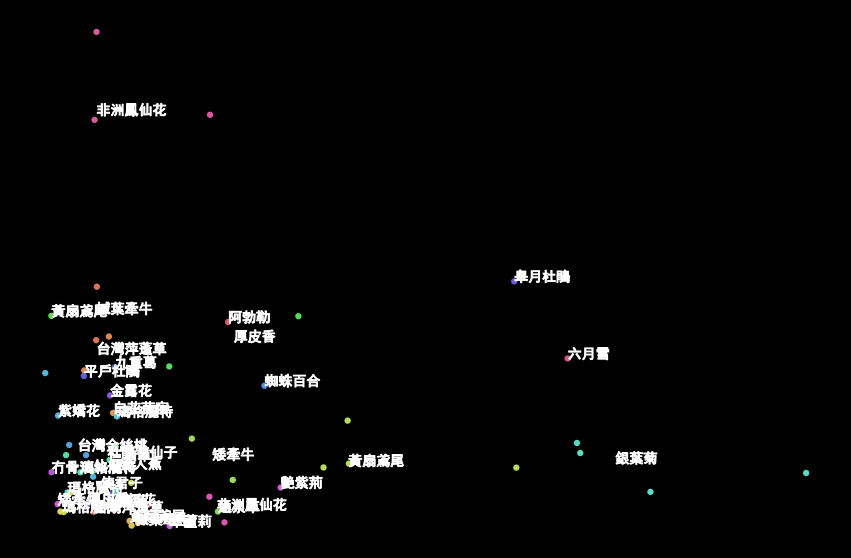

In [20]:
fashion_scatter(pca_result, Y, text) # Visualizing the PCA output